In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import signal

from shapely.geometry import Point

## Emplacement des stations

In [3]:
fleuve = "Rhone"

tableau_stations_file = "../Data/Extraction_Hydro/" + fleuve + "/Stations.csv"
tableau_stations = pd.read_csv(tableau_stations_file, encoding="UTF-8",
                              delimiter=";")
tableau_stations = gpd.GeoDataFrame(tableau_stations)
n_stations = tableau_stations.shape[0]

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

In [4]:
tableau_stations['geometry'] = tableau_stations.apply(lambda x: Point(float(x['X (m)']), float(x['Y (m)'])), axis = 1)
tableau_stations = tableau_stations.set_crs('EPSG:27572')
tableau_stations = tableau_stations.to_crs(world.crs)
tableau_stations

,Code station,Libelle station,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,Regime influencé,Altitude du zéro de l'échelle,Coordonnées,X (m),Y (m),geometry
0,V1020020,Le Rhône à Surjoux,True,True,True,True,True,True,True,True,True,True,True,fortement,259.50,Lambert II Étendu,868970,2119350,POINT (5.81129 46.02087)
1,V4570010,Le Rhône à Bourg-Saint-Andéol,True,True,True,True,True,True,True,True,True,True,True,pas ou faiblement,44.87,Lambert II Étendu,784287,1932392,POINT (4.64713 44.36825)
2,V4571010,Le Rhône à Pont-Saint-Esprit,True,True,True,True,True,True,True,True,True,True,True,NaN,NaN,Lambert II Étendu,784600,1920390,POINT (4.64663 44.26029)
3,V7200005,Le Rhône à Beaucaire [Pont de Beaucaire],True,True,True,True,True,True,True,True,True,True,True,fortement,NaN,Lambert II Étendu,786290,1869730,POINT (4.64913 43.80458)
4,V7200015,Le Rhône à Tarascon [Beaucaire-Tarascon],True,True,True,True,True,True,True,True,True,True,True,NaN,NaN,Lambert II Étendu,786650,1867850,POINT (4.65291 43.78759)


<AxesSubplot:>

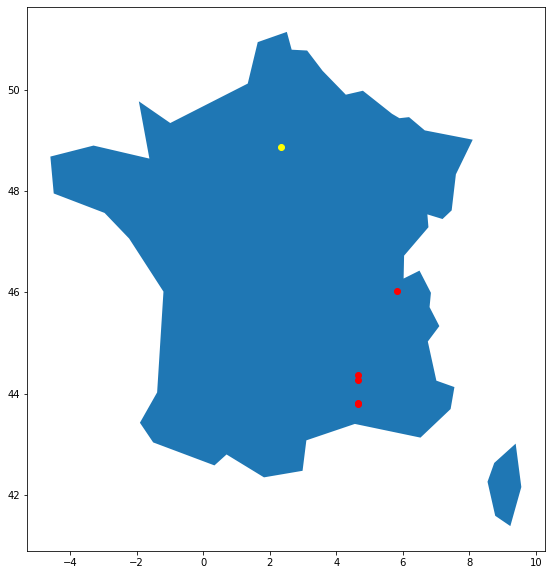

In [5]:
france = world[world['name'] == "France"].geometry.explode()[[1,2]].unary_union

base = gpd.GeoSeries(france).plot(figsize = (10, 10))
tableau_stations.plot(ax = base, color = "red")
cities[cities['name'] == "Paris"].plot(ax = base, color = "yellow")

On trie les stations du Nord au Sud.

In [6]:
tableau_stations["Ord"] = tableau_stations["geometry"].apply(lambda x: x.coords[:][0][1])
tableau_stations["Abs"] = tableau_stations["geometry"].apply(lambda x: x.coords[:][0][0])

tri = tableau_stations.sort_values(by = "Ord", ascending=False)[["Code station"]]
for i in range(n_stations):
    code = tri["Code station"][i]
    tableau_stations.loc[tableau_stations["Code station"] == code,"Ordre"] = i

station_amont_pt = tableau_stations["geometry"].to_crs("EPSG:32633")[tableau_stations["Ordre"].values.argmin()]
tableau_stations["Distance amont"] = tableau_stations["geometry"].to_crs("EPSG:32633").distance(station_amont_pt)
tableau_stations

,Code station,Libelle station,2010,2011,2012,2013,2014,2015,2016,2017,...,Regime influencé,Altitude du zéro de l'échelle,Coordonnées,X (m),Y (m),geometry,Ord,Abs,Ordre,Distance amont
0,V1020020,Le Rhône à Surjoux,True,True,True,True,True,True,True,True,...,fortement,259.50,Lambert II Étendu,868970,2119350,POINT (5.81129 46.02087),46.020874,5.811290,0.0,0.000000
1,V4570010,Le Rhône à Bourg-Saint-Andéol,True,True,True,True,True,True,True,True,...,pas ou faiblement,44.87,Lambert II Étendu,784287,1932392,POINT (4.64713 44.36825),44.368250,4.647132,1.0,206590.569462
2,V4571010,Le Rhône à Pont-Saint-Esprit,True,True,True,True,True,True,True,True,...,NaN,NaN,Lambert II Étendu,784600,1920390,POINT (4.64663 44.26029),44.260290,4.646634,2.0,217525.654966
3,V7200005,Le Rhône à Beaucaire [Pont de Beaucaire],True,True,True,True,True,True,True,True,...,fortement,NaN,Lambert II Étendu,786290,1869730,POINT (4.64913 43.80458),43.804577,4.649128,3.0,264657.828088
4,V7200015,Le Rhône à Tarascon [Beaucaire-Tarascon],True,True,True,True,True,True,True,True,...,NaN,NaN,Lambert II Étendu,786650,1867850,POINT (4.65291 43.78759),43.787590,4.652907,4.0,266340.071767


<AxesSubplot:>

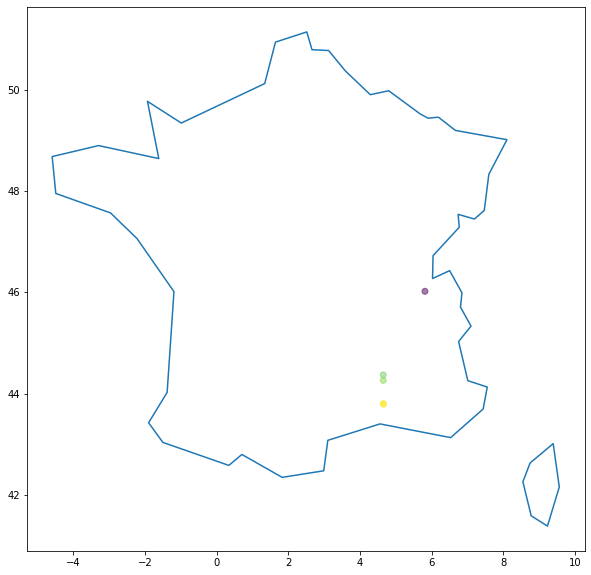

In [7]:
base = gpd.GeoSeries(france).boundary.plot(figsize = (10, 10))
dist_aval = tableau_stations["Distance amont"].values.max()
tableau_stations.plot(ax = base, color = cm.get_cmap("viridis")(tableau_stations["Distance amont"]/dist_aval), alpha = 0.5)

## On rassemble les années

In [8]:
# Initialisation
annees = [a for a in range(2010, 2021)]

for c_annee in annees:
    print(c_annee)
    
    station_dates = tableau_stations["Code station"][tableau_stations[str(c_annee)]].values[0] #Une station avec cette annee présente
    mesures_annee = pd.read_csv("../Data/Extraction_Hydro/" + fleuve + "/" + station_dates + "_" + str(c_annee) + ".csv",
                                sep = ";")[["Date"]]
    
    for i in range(n_stations):
        code = tableau_stations[tableau_stations["Ordre"] == i]["Code station"].values[0]
        if tableau_stations[tableau_stations["Ordre"] == i][str(c_annee)].values[0]:
            station = pd.read_csv("../Data/Extraction_Hydro/" + fleuve +"/" + code + "_" + str(c_annee) + ".csv",
                                  sep = ";")
            station = station.rename(columns = {"Q (m3/s)": code})
            mesures_annee = mesures_annee.merge(station[["Date", code]],
                                                on = "Date",
                                                how = "outer")
        else:
            mesures_annee[code] = None
    
    mesures_annee["Date"] = pd.to_datetime(mesures_annee["Date"], format = "%d/%m/%Y %H:%M")
    mesures_annee = mesures_annee.sort_values(by = "Date")
    mesures_annee.to_csv("../Data/Extraction_Hydro/" + fleuve + "/Mesures_" + str(c_annee) + ".csv",
                        index = False)

2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [9]:
mesures = pd.read_csv("../Data/Extraction_Hydro/" + fleuve + "/Mesures_2010.csv")
mesures["Date"] = pd.to_datetime(mesures["Date"], format = "%Y/%m/%d %H:%M:%S")

for c_annee in annees[1:]:
    print(c_annee)
    mesures_annee = pd.read_csv("../Data/Extraction_Hydro/" + fleuve + "/Mesures_" + str(c_annee) + ".csv")
    mesures_annee["Date"] = pd.to_datetime(mesures_annee["Date"], format = "%Y/%m/%d %H:%M:%S")
    mesures = pd.concat([mesures, mesures_annee])
mesures = mesures.sort_values(by = "Date")
mesures.to_csv("../Data/Extraction_Hydro/" + fleuve + "/Mesures.csv",
                        index = False)

2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [10]:
mesures.head()

,Date,V1020020,V4570010,V4571010,V7200005,V7200015
0,2010-01-01 00:00:00,459.0,828.0,828.0,1130.0,3190.0
1,2010-01-01 02:00:00,319.0,749.0,767.0,1100.0,3190.0
2,2010-01-01 04:00:00,405.0,703.0,707.0,1060.0,3180.0
3,2010-01-01 06:00:00,543.0,886.0,730.0,1040.0,3160.0
4,2010-01-01 08:00:00,570.0,1080.0,930.0,1050.0,3160.0


## Explorations

In [11]:
mesures = pd.read_csv("../Data/Extraction_Hydro/" + fleuve + "/Mesures.csv")
mesures["Date"] = pd.to_datetime(mesures["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures.describe(include = "all")

,Date,V1020020,V4570010,V4571010,V7200005,V7200015
count,48216,47460.000000,48216.000000,48216.000000,46384.000000,48205.000000
unique,48216,NaN,NaN,NaN,NaN,NaN
top,2010-07-31 10:00:00,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
first,2010-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
last,2020-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,351.948618,241.617897,314.572804,281.978420,1591.841377
std,NaN,225.456615,412.480923,433.114556,489.373101,955.857818
min,NaN,10.300000,47.900000,85.500000,7.460000,29.400000
25%,NaN,128.000000,75.600000,111.000000,52.600000,867.000000


C:\Users\zhouj\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


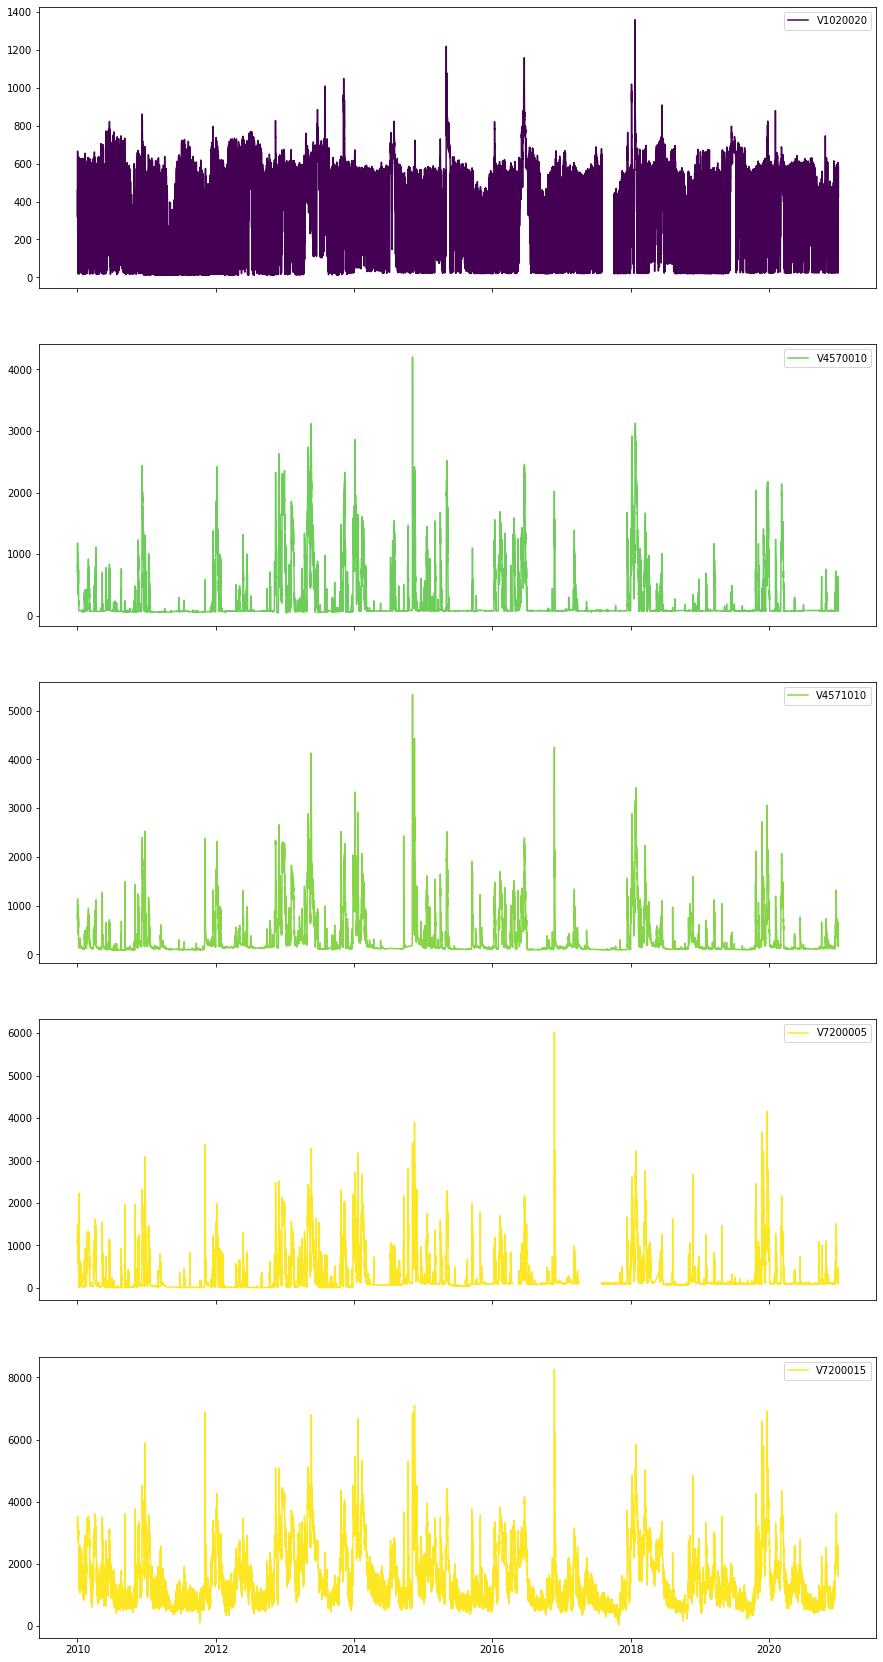

In [12]:
n_stations = tableau_stations.shape[0]
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = tableau_stations[tableau_stations["Ordre"] == i]["Code station"].values[0]
    axs[i].plot(mesures["Date"], mesures[code], label = code, 
                color = cm.get_cmap("viridis")(tableau_stations.loc[i, "Distance amont"]/dist_aval))
    axs[i].legend()

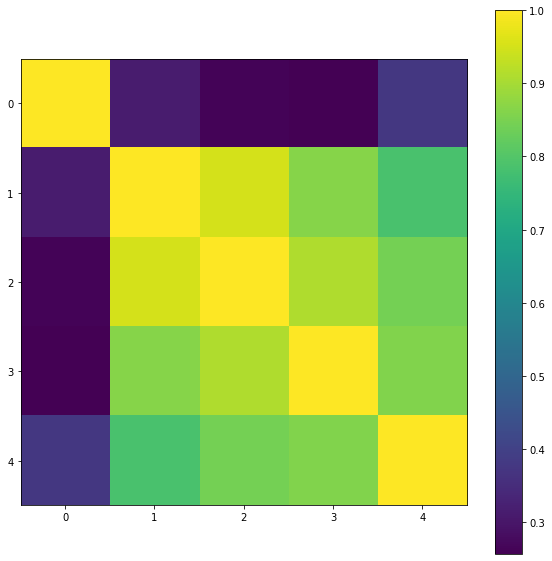

In [13]:
fig, ax = plt.subplots(figsize = (10, 10))
im = ax.imshow(mesures.corr())
fig.colorbar(im)

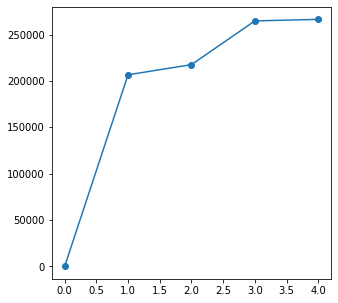

In [14]:
# Voir la répartition les distances
fig, ax = plt.subplots(figsize = (5,5))
ax.plot(tableau_stations["Ordre"], 
        tableau_stations["Distance amont"],
       marker = "o")

## Nettoyage

In [15]:
mesures.describe(include = "all")

,Date,V1020020,V4570010,V4571010,V7200005,V7200015
count,48216,47460.000000,48216.000000,48216.000000,46384.000000,48205.000000
unique,48216,NaN,NaN,NaN,NaN,NaN
top,2010-07-31 10:00:00,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
first,2010-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
last,2020-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,351.948618,241.617897,314.572804,281.978420,1591.841377
std,NaN,225.456615,412.480923,433.114556,489.373101,955.857818
min,NaN,10.300000,47.900000,85.500000,7.460000,29.400000
25%,NaN,128.000000,75.600000,111.000000,52.600000,867.000000


A priori, on garde les stations avec les mesures complètes

In [16]:
proportion_mesures = mesures.drop("Date", axis = 1).count()/len(mesures)
proportion_mesures

V1020020    0.984321
V4570010    1.000000
V4571010    1.000000
V7200005    0.962004
V7200015    0.999772
dtype: float64

In [17]:
stations_complet = []
stations_incomplet = []
for idx, row in proportion_mesures.iteritems():
    if row < 1:
        stations_incomplet.append(idx)
    else:
        stations_complet.append(idx)
stations_incomplet

['V1020020', 'V7200005', 'V7200015']

In [18]:
proportion_mesures[stations_incomplet]

V1020020    0.984321
V7200005    0.962004
V7200015    0.999772
dtype: float64

In [19]:
mesures[["Date"] + stations_incomplet]

,Date,V1020020,V7200005,V7200015
0,2010-01-01 00:00:00,459.0,1130.0,3190.0
1,2010-01-01 02:00:00,319.0,1100.0,3190.0
2,2010-01-01 04:00:00,405.0,1060.0,3180.0
3,2010-01-01 06:00:00,543.0,1040.0,3160.0
4,2010-01-01 08:00:00,570.0,1050.0,3160.0
...,...,...,...,...
48211,2020-12-31 14:00:00,579.0,118.0,1980.0
48212,2020-12-31 16:00:00,588.0,112.0,1980.0
48213,2020-12-31 18:00:00,573.0,111.0,1960.0
48214,2020-12-31 20:00:00,497.0,111.0,1890.0


In [20]:
mesures[stations_incomplet].isna().sum()

V1020020     756
V7200005    1832
V7200015      11
dtype: int64

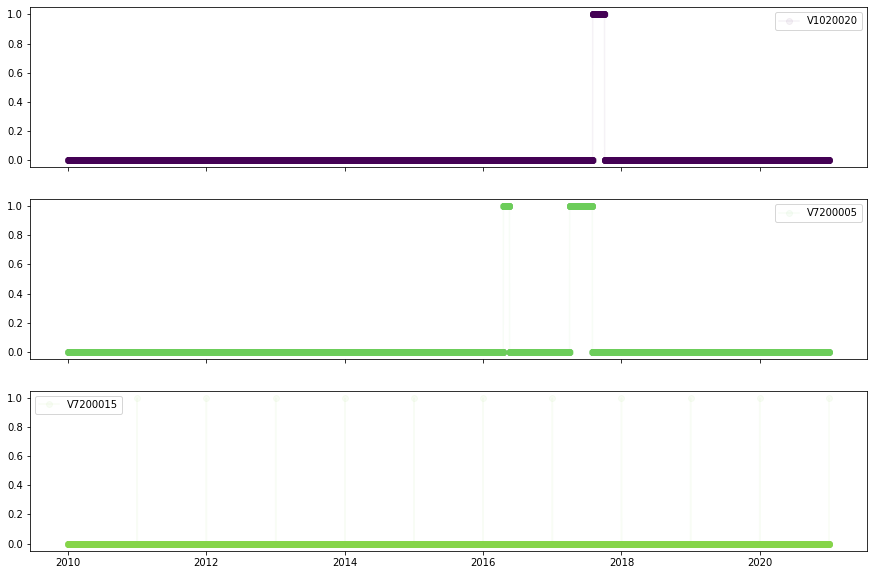

In [21]:
fig, axs = plt.subplots(len(stations_incomplet), 1, figsize = (15,10), sharex=True)
for i in range(len(stations_incomplet)):
    code = stations_incomplet[i]
    axs[i].plot(mesures["Date"], np.isnan(mesures[code]), label = code, 
                color = cm.get_cmap("viridis")(tableau_stations.loc[i, "Distance amont"]/dist_aval), marker = "o", alpha = 0.05)
    axs[i].legend()

On va garder les stations:
- V7200015 

In [22]:
stations_interpoler = ["V7200015"]

In [23]:
mesures[["Date"] + stations_interpoler]

,Date,V7200015
0,2010-01-01 00:00:00,3190.0
1,2010-01-01 02:00:00,3190.0
2,2010-01-01 04:00:00,3180.0
3,2010-01-01 06:00:00,3160.0
4,2010-01-01 08:00:00,3160.0
...,...,...
48211,2020-12-31 14:00:00,1980.0
48212,2020-12-31 16:00:00,1980.0
48213,2020-12-31 18:00:00,1960.0
48214,2020-12-31 20:00:00,1890.0


In [24]:
for code in stations_interpoler:
    mesures[code] = mesures[code].interpolate()

Les stations au total.

In [26]:
stations_garder = stations_complet + stations_interpoler
stations_garder

['V4570010', 'V4571010', 'V7200015']

In [27]:
tableau_garder = tableau_stations[tableau_stations["Code station"] == stations_garder[0]]
for code in stations_garder[1:]:
    tableau_garder = pd.concat([tableau_garder, tableau_stations[tableau_stations["Code station"] == code]])

# On remet dans l'ordre et garde les colonnes importantes
tableau_garder = tableau_garder.sort_values(by = "Ordre")
tableau_garder["Ordre"] = [i for i in range(tableau_garder.shape[0])]

tableau_garder = tableau_garder[["Code station", "Libelle station", "Regime influencé", "Altitude du zéro de l'échelle", "geometry", "Ordre", ]]
tableau_garder

,Code station,Libelle station,Regime influencé,Altitude du zéro de l'échelle,geometry,Ordre
1,V4570010,Le Rhône à Bourg-Saint-Andéol,pas ou faiblement,44.87,POINT (4.64713 44.36825),0
2,V4571010,Le Rhône à Pont-Saint-Esprit,NaN,NaN,POINT (4.64663 44.26029),1
4,V7200015,Le Rhône à Tarascon [Beaucaire-Tarascon],NaN,NaN,POINT (4.65291 43.78759),2


On a plus grand chose, et juste une station avec l'altitude, on va pas garder.